# Modelamiento para el Dataset de Calificaciones

In [115]:
# Importa las bibliotecas necesarias para desarrollar el experimento.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

In [116]:

# Estilo BlueLight personalizado
def configurar_estilo_bluelight():
    sns.set_theme(style="whitegrid")
    plt.rcParams.update({
        "axes.facecolor": "#F5F9FF",
        "figure.facecolor": "#F5F9FF",
        "axes.edgecolor": "#CCCCCC",
        "axes.labelcolor": "#333333",
        "xtick.color": "#333333",
        "ytick.color": "#333333",
        "text.color": "#003366",
        "axes.titleweight": "bold",
        "axes.titlesize": 14,
        "axes.titlecolor": "#003366"
    })

In [117]:

# --------------------------------------------
# 1. Cargar y limpiar los datos del colegio
# --------------------------------------------
def limpiar_datos_colegio(df):
    
    df['Docente'] = df['Docente'].replace('INVESTIGACIÓNNICOLÁS CONTRERAS ANAVE', 'NICOLÁS CONTRERAS ANAVE')

    return df 

In [118]:
def codificar_variables(df):
    mapeos = {}

    # Mapear Sede
    mapeos['Sede'] = {'FUSAGASUGÁ': 1, 'GIRARDOT': 2}
    df['Sede'] = df['Sede'].replace(mapeos['Sede'])

    # Mapear Grupo
    mapeos['Grupo'] = {'A': 1, 'B': 2}
    df['Grupo'] = df['Grupo'].replace(mapeos['Grupo'])

    # Mapear Nivel
    mapeos['Nivel'] = {'SUPERIOR': 1, 'ALTO': 2, 'BÁSICO': 3, 'BAJO': 4}
    df['Nivel'] = df['Nivel'].replace(mapeos['Nivel'])

    # Categorías con códigos para Asignatura y Docente
    for col in ['Asignatura', 'Docente']:
        categorias = df[col].astype('category').cat.categories
        mapping = {cat: code + 1 for code, cat in enumerate(categorias)}
        df[col] = df[col].map(mapping)
        mapeos[col] = mapping

    return df, mapeos


In [119]:
# --------------------------------------------
# 2. Imputacion de valores faltantes usando KNNImpute los datos del colegio
# --------------------------------------------
def imputar_datos_notas(df):
    imputer = KNNImputer(n_neighbors=5)
    cols_a_imputar = ["Cog", "Proc"]  # o las columnas que consideres relevantes
    df[cols_a_imputar] = imputer.fit_transform(df[cols_a_imputar])
    return df


In [120]:
# Función para aplicar mapeos a datos nuevos
def aplicar_mapeos(df, mapeos):
    for col, mapping in mapeos.items():
        df[col] = df[col].map(mapping)
    return df

# Ejemplo de uso en datos nuevos (por ejemplo, df_nuevo)
# df_nuevo = pd.read_csv("datos_nuevos.csv")
# df_nuevo = limpiar_datos_colegio(df_nuevo)
# df_nuevo = aplicar_mapeos(df_nuevo, mapeos)

In [121]:
def separar_X_y(df):
    X = df.drop(["Resultado", "Identificación", "Estudiante"], axis=1)
    y = df["Resultado"]
    return X, y

def dividir_datos(X, y, test_size=0.3, random_state=42):
    return train_test_split(X, y, test_size=test_size, random_state=random_state)

def normalizar_datos(X_train, X_test=None, scaler=None):
    from sklearn.preprocessing import StandardScaler
    if scaler is None:
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
    else:
        X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test) if X_test is not None else None
    return X_train_scaled, X_test_scaled, scaler


In [122]:
# Paso 0: cargar datos
df_raw = pd.read_csv("../../data/processed/data_clean_notes_2023_2025.csv")

# Paso 1: limpiar datos
df_clean = limpiar_datos_colegio(df_raw.copy())


# Paso 2: codificar variables categóricas
df_clean, mapeos = codificar_variables(df_clean)

# Paso 3: imputar valores faltantes
df_imputed = imputar_datos_notas(df_clean)

# Paso 4: separar características y objetivo
X, y = separar_X_y(df_imputed)

# Paso 5: dividir en train y test
X_train, X_test, y_train, y_test = dividir_datos(X, y)

# Paso 6: normalizar características
X_train_scaled, X_test_scaled, scaler = normalizar_datos(X_train, X_test)



C:\Users\Cathe\AppData\Local\Temp\ipykernel_34124\248588733.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Sede'] = df['Sede'].replace(mapeos['Sede'])
C:\Users\Cathe\AppData\Local\Temp\ipykernel_34124\248588733.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Grupo'] = df['Grupo'].replace(mapeos['Grupo'])
C:\Users\Cathe\AppData\Local\Temp\ipykernel_34124\248588733.py:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly ca

# 1. Experimento con Regression Lineal

In [123]:
# ------------------------------------------------------------------
# Paso 7 → 9  :  validación cruzada, entrenamiento final y gráficas
# ------------------------------------------------------------------
# Función para regresión lineal OLS
def entrenar_regresion_lineal(X_train_scaled, X_test_scaled,y_train,y_test, cv_folds=5, plot_tipo=2,primera_feature_name=None):
    
    model = LinearRegression()

    # --- Validación cruzada ---
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=cv_folds, scoring='r2')
    print(f"\n[Regresión Lineal] R² en {cv_folds} folds: {cv_scores}")
    print(f"Promedio R² CV: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

    # --- Entrenamiento final + predicción ---
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    print("\n--- Métricas en test -----------------------")
    print(f"MSE: {mean_squared_error(y_test, y_pred):.2f}")
    print(f"R² : {r2_score(y_test, y_pred):.2f}")
    print("\nCoeficientes (primeros 10):", np.round(model.coef_[:10], 4))
    print("Intercepto:", round(model.intercept_, 4))

    # --- Gráfica ---
    configurar_estilo_bluelight()

    if plot_tipo == 1:
        plt.scatter(X_test_scaled[:, 0], y_test, color="black")
        plt.plot(X_test_scaled[:, 0], y_pred, color="blue", linewidth=1)
        plt.xlabel(primera_feature_name)
        plt.ylabel("Resultado")
        plt.title("Real vs Predicción (Regresión Lineal Simple)")
    else:
        plt.scatter(y_test, y_pred, color="blue")
        plt.plot([y_test.min(), y_test.max()],
                 [y_test.min(), y_test.max()], 'r--')
        plt.xlabel("Valores reales")
        plt.ylabel("Valores predichos")
        plt.title("Real vs Predicción (Regresión Lineal Múltiple)")

    plt.show()
    return model, cv_scores, y_pred



[Regresión Lineal] R² en 5 folds: [0.97798631 0.9793021  0.97279587 0.96209532 0.94985816]
Promedio R² CV: 0.968 ± 0.011

--- Métricas en test -----------------------
MSE: 2.13
R² : 0.97

Coeficientes (primeros 10): [-0.0119  0.0182  0.0032  0.0089 -0.0087 -0.0219 -0.0437  3.016   3.1785
  1.3393]
Intercepto: 85.4301


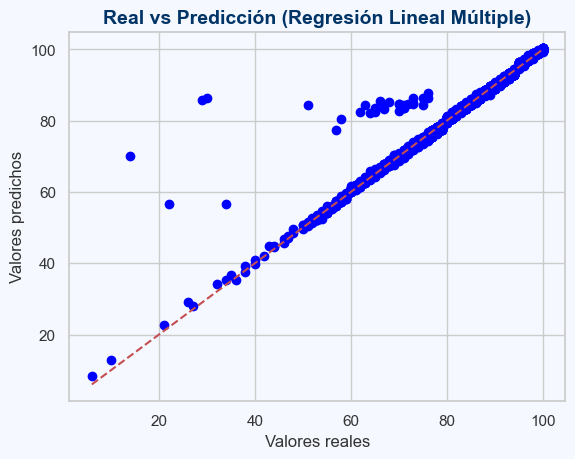

In [124]:
modelo_lineal, cv_lineal, ypred_lineal = entrenar_regresion_lineal(
    X_train_scaled, X_test_scaled, y_train,y_test,cv_folds=5, plot_tipo=2
)


# 2. Experimento con Ridge y GridSearchCV

In [125]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

def buscar_mejor_ridge(X_train_scaled, y_train, X_test_scaled, y_test, alphas=None, cv_folds=5, plot_tipo=2):
    if alphas is None:
        alphas = [0.01, 0.1, 1.0, 10.0, 50.0, 100.0]

    ridge = Ridge()
    parametros = {"alpha": alphas}

    grid = GridSearchCV(ridge, parametros, scoring='r2', cv=cv_folds)
    grid.fit(X_train_scaled, y_train)

    mejor_modelo = grid.best_estimator_
    mejor_alpha = grid.best_params_['alpha']
    print(f"Mejor alpha encontrado: {mejor_alpha}")

    # Validación cruzada
    print(f"Mejor R² CV promedio: {grid.best_score_:.3f}")

    # Evaluación en test
    y_pred = mejor_modelo.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print("\n--- Métricas en test -----------------------")
    print(f"MSE: {mse:.2f}")
    print(f"R² : {r2:.2f}")
    print("Coeficientes (primeros 10):", mejor_modelo.coef_[:10])
    print(f"Intercepto: {mejor_modelo.intercept_:.4f}")

    # Gráfica
    configurar_estilo_bluelight()
    if plot_tipo == 1:
        plt.scatter(X_test_scaled[:, 0], y_test, color="black")
        plt.plot(X_test_scaled[:, 0], y_pred, color="blue", linewidth=1)
        plt.xlabel("Primera característica")
        plt.ylabel("nota_siguiente")
        plt.title("Ridge simple: Real vs Predicción")
    else:
        plt.scatter(y_test, y_pred, color="blue")
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
        plt.xlabel("Valores reales")
        plt.ylabel("Valores predichos")
        plt.title("Ridge múltiple: Real vs Predicción")

    plt.show()
    
    return mejor_modelo


Mejor alpha encontrado: 3.5111917342151346
Mejor R² CV promedio: 0.968

--- Métricas en test -----------------------
MSE: 2.13
R² : 0.97
Coeficientes (primeros 10): [-1.19326177e-02  1.81183902e-02  3.16866285e-03  8.93594786e-03
 -8.73640412e-03 -2.20728460e-02 -4.37311821e-02  3.01554069e+00
  3.17764592e+00  1.33924306e+00]
Intercepto: 85.4301


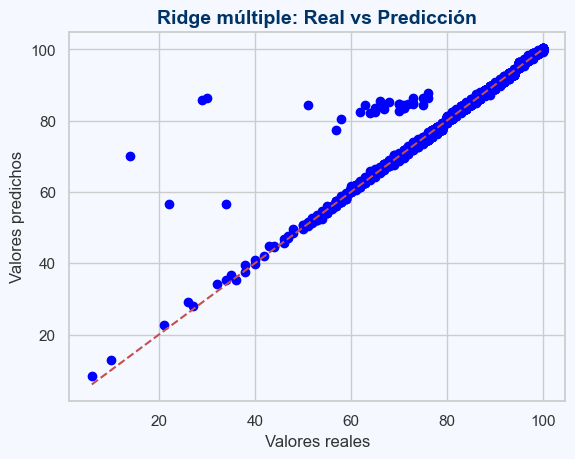

In [127]:
alphas_a_probar = np.logspace(-4, 2, 100)
modelo_ridge_optimo = buscar_mejor_ridge(X_train_scaled, y_train, X_test_scaled, y_test, alphas=alphas_a_probar)



# 3. Experimento con Keras y 2 capas ocultas  de 50 neuronas y de 25 neuronas

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

def entrenar_red_neuronal_keras_reg(X_train, y_train, X_val, y_val,
                                    hidden_layers=[50, 25],
                                    l2_lambda=0.01,
                                    dropout_rate=0.2,
                                    epochs=50,
                                    batch_size=32,
                                    patience=50):
 
    model = Sequential()
    input_dim = X_train.shape[1]

    # Primera capa oculta con input_shape y L2 + Dropout
    model.add(Dense(hidden_layers[0], activation='relu',
                    kernel_regularizer=l2(l2_lambda),
                    input_shape=(input_dim,)))
    model.add(Dropout(dropout_rate))

    # Capas ocultas siguientes
    for neurons in hidden_layers[1:]:
        model.add(Dense(neurons, activation='relu',
                        kernel_regularizer=l2(l2_lambda)))
        model.add(Dropout(dropout_rate))

    # Capa de salida (1 neurona, regresión)
    model.add(Dense(1))

    # Compilar modelo
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    # Early stopping para evitar overfitting
    early_stop = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

    # Entrenar
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stop],
        verbose=1
    )

    return model, history

In [ ]:
# Entrenar la red neuronal Keras para regresión
modelo_keras, historia = entrenar_red_neuronal_keras_reg(
    X_train_scaled, y_train,
    X_test_scaled, y_test,
    hidden_layers=[50, 25],
    l2_lambda=0.01,
    dropout_rate=0.1,
    epochs=50,
    batch_size=32,
    patience=50
)

Epoch 1/50


c:\Users\Cathe\.conda\envs\cloud_computing\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


715/715 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 3800.2773 - mae: 53.0704 - val_loss: 98.3676 - val_mae: 7.2764
Epoch 2/50
715/715 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 162.1874 - mae: 9.9624 - val_loss: 38.9536 - val_mae: 4.5173
Epoch 3/50
715/715 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 117.1510 - mae: 8.5229 - val_loss: 20.6038 - val_mae: 3.1162
Epoch 4/50
715/715 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 97.3961 - mae: 7.7641 - val_loss: 12.4716 - val_mae: 2.2489
Epoch 5/50
715/715 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 90.0337 - mae: 7.4100 - val_loss: 9.6587 - val_mae: 1.9326
Epoch 6/50
715/715 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 85.1958 - mae: 7.2424 - val_loss: 7.6037 - val_mae: 1.5939
Epoch 7/50
715/715 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 82.1657 - mae: 7.1058 - val_loss: 7.2341 - val_mae: 1.6661
Epoch 8/50
715/715 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 79.5757 - mae: 6.9867 - val_loss: 7.1428 - val_mae: 1.6479
Epoch 9/50
715/715 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/ste

In [ ]:
# Evaluar en test
mse, mae = modelo_keras.evaluate(X_test_scaled, y_test, verbose=0)
print(f"MSE Keras regularizado: {mse:.3f}, MAE: {mae:.3f}")

# Predicción
y_pred_keras = modelo_keras.predict(X_test_scaled)

from sklearn.metrics import r2_score
r2_keras = r2_score(y_test, y_pred_keras)
print(f"R² Keras regularizado: {r2_keras:.3f}")

MSE Keras regularizado: 2.767, MAE: 0.624
307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 845us/step
R² Keras regularizado: 0.965


In [ ]:
print(modelo_keras.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_35 (Dense)                │ (None, 50)             │           700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,005 (23.46 KB)

 Trainable params: 2,001 (7.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,004 (15.64 KB)

None



--- Visualización del Historial de Entrenamiento ---


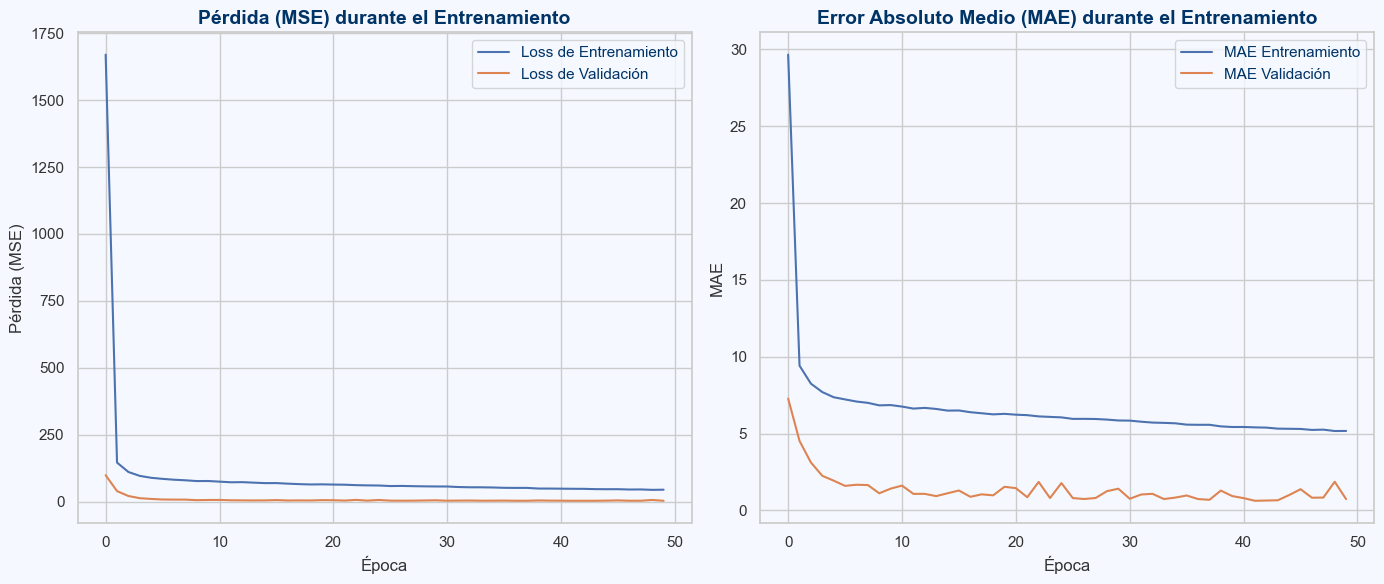

In [ ]:
# --- Visualización del Historial de Entrenamiento ---
print("\n--- Visualización del Historial de Entrenamiento - Experimento 3 ---")

hist = historia.history
epochs = range(len(hist['loss']))

plt.figure(figsize=(14, 6))

# Pérdida (MSE) en entrenamiento y validación
plt.subplot(1, 2, 1)
plt.plot(epochs, hist['loss'], label='Loss de Entrenamiento')
plt.plot(epochs, hist['val_loss'], label='Loss de Validación')
plt.title('Pérdida (MSE) durante el Entrenamiento')
plt.xlabel('Época')
plt.ylabel('Pérdida (MSE)')
plt.legend()
plt.grid(True)

# MAE en entrenamiento y validación
plt.subplot(1, 2, 2)
plt.plot(epochs, hist['mae'], label='MAE Entrenamiento')
plt.plot(epochs, hist['val_mae'], label='MAE Validación')
plt.title('Error Absoluto Medio (MAE) durante el Entrenamiento')
plt.xlabel('Época')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## 3.1. Conclusiones experimento 3

Parámetros Actuales del Modelo y sus Implicaciones
A continuación, se presentan los principales hiperparámetros utilizados en la configuración actual del modelo, junto con una breve discusión sobre su impacto:

Capas ocultas (hidden_layers=[50, 25]): El modelo cuenta con dos capas ocultas compuestas por 50 y 25 neuronas, respectivamente. Considerando que el conjunto de datos posee solo 13 características de entrada, esta arquitectura puede considerarse relativamente compleja, lo cual incrementa el riesgo de sobreajuste.

Regularización L2 (l2_lambda=0.01): Se ha aplicado regularización L2 (también conocida como Ridge), la cual penaliza los pesos grandes del modelo. Esta estrategia contribuye a reducir la complejidad del modelo y ayuda a mitigar el sobreajuste, representando un punto de partida adecuado para controlar la generalización.

Tasa de Dropout (dropout_rate=0.1): Durante el entrenamiento, se desactivan aleatoriamente algunas neuronas con una probabilidad del 10 %. Esta técnica busca forzar a la red a aprender representaciones más robustas y menos dependientes de rutas específicas. No obstante, el valor actual de 0.1 es bajo y podría evaluarse un aumento para mejorar la regularización.

Número de épocas (epochs=50): Se estableció un límite de 50 épocas para el entrenamiento del modelo, lo cual puede ser razonable en función del tamaño y complejidad del conjunto de datos.

Tamaño del lote (batch_size=32): Se utiliza un tamaño de lote estándar de 32 ejemplos por iteración, lo cual ofrece un equilibrio adecuado entre estabilidad y eficiencia computacional.

Paciencia del Early Stopping (patience=50): Se ha configurado una paciencia igual al número total de épocas, lo que en la práctica impide que el mecanismo de early stopping se active, ya que requeriría 50 épocas consecutivas sin mejora para detener el entrenamiento. Este parámetro debería ajustarse para que el mecanismo cumpla su función de prevenir sobreentrenamiento.


# 4. Experimento con Keras con 2 capas ocultas y ajuste de hiper parametros para evitar sobreajuste

In [ ]:
# Entrenar la red neuronal Keras para regresión
modelo_keras, historia = entrenar_red_neuronal_keras_reg(
    X_train_scaled, y_train,
    X_test_scaled, y_test,
   hidden_layers=[20, 10],   # Menos neuronas
    l2_lambda=0.05,          # Aumentar regularización L2
    dropout_rate=0.3,        # Aumentar dropout
    epochs=200,              # Más épocas (con Early Stopping efectivo)
    batch_size=64,           # Opcional: Probar batch_size más grande (puede ayudar a la generalización)
    patience=15              # Reducir la paciencia para Early Stopping
)

c:\Users\Cathe\.conda\envs\cloud_computing\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
358/358 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 6479.8667 - mae: 79.3328 - val_loss: 1579.3390 - val_mae: 36.1174
Epoch 2/200
358/358 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1550.8199 - mae: 33.3759 - val_loss: 326.7715 - val_mae: 15.1818
Epoch 3/200
358/358 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 935.9822 - mae: 24.7959 - val_loss: 188.9102 - val_mae: 11.5392
Epoch 4/200
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 830.9296 - mae: 23.3857 - val_loss: 134.8320 - val_mae: 9.8537
Epoch 5/200
358/358 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 788.0125 - mae: 22.6324 - val_loss: 112.0685 - val_mae: 9.1234
Epoch 6/200
358/358 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 739.3586 - mae: 22.0400 - val_loss: 108.8229 - val_mae: 9.2473
Epoch 7/200
358/358 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 702.4708 - mae: 21.3271 - val_loss: 94.1364 - val_mae: 8.7097
Epoch 8/200
358/358 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 646.0699 - mae: 20.4980 - val_loss: 74.5429 - val_mae: 7.7558
Epoc

In [ ]:
# Evaluar en test
mse, mae = modelo_keras.evaluate(X_test_scaled, y_test, verbose=0)
print(f"MSE Keras regularizado: {mse:.3f}, MAE: {mae:.3f}")

# Predicción
y_pred_keras = modelo_keras.predict(X_test_scaled)

from sklearn.metrics import r2_score
r2_keras = r2_score(y_test, y_pred_keras)
print(f"R² Keras regularizado: {r2_keras:.3f}")

MSE Keras regularizado: 19.810, MAE: 3.933
307/307 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
R² Keras regularizado: 0.731


In [ ]:
print(modelo_keras.summary())

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_59 (Dense)                │ (None, 20)             │           280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 10)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,505 (5.88 KB)

 Trainable params: 501 (1.96 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,004 (3.93 KB)

None



--- Visualización del Historial de Entrenamiento - Experimento 4 ---


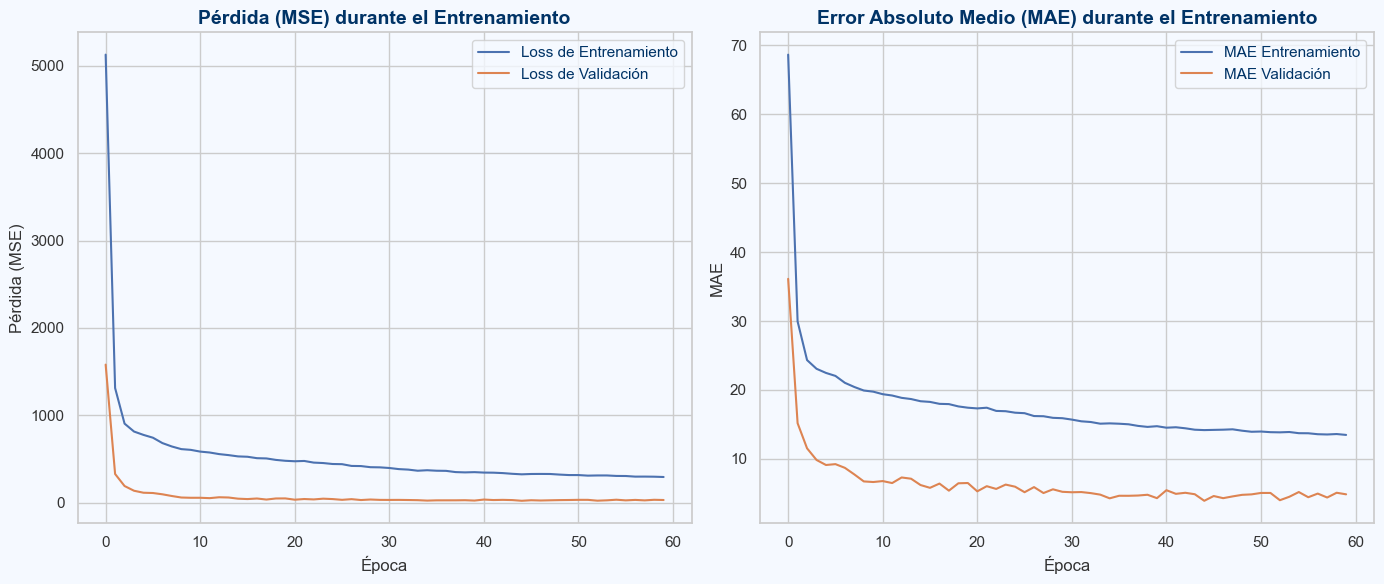

In [ ]:
# --- Visualización del Historial de Entrenamiento ---
print("\n--- Visualización del Historial de Entrenamiento - Experimento 4 ---")

hist = historia.history
epochs = range(len(hist['loss']))

plt.figure(figsize=(14, 6))

# Pérdida (MSE) en entrenamiento y validación
plt.subplot(1, 2, 1)
plt.plot(epochs, hist['loss'], label='Loss de Entrenamiento')
plt.plot(epochs, hist['val_loss'], label='Loss de Validación')
plt.title('Pérdida (MSE) durante el Entrenamiento')
plt.xlabel('Época')
plt.ylabel('Pérdida (MSE)')
plt.legend()
plt.grid(True)

# MAE en entrenamiento y validación
plt.subplot(1, 2, 2)
plt.plot(epochs, hist['mae'], label='MAE Entrenamiento')
plt.plot(epochs, hist['val_mae'], label='MAE Validación')
plt.title('Error Absoluto Medio (MAE) durante el Entrenamiento')
plt.xlabel('Época')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()